# Group Project Report

### Introduction

In school, the way used to measure a student’s knowledge is often through exams. To do well on exams, students often resort to spending as much time as possible to study in preparation for them. We want to investigate whether study time and exam results have an impact on a person’s knowledge level of that subject.

**The question we are trying to answer is: based on the time they spend studying and exam performance, what knowledge level would the user have on a subject?**

We are using the [User Knowledge Modeling](https://archive.ics.uci.edu/dataset/257/user+knowledge+modeling) dataset from the UCI Machine Learning Repository. There 403 observations which have been already split – 258 in the training dataset, and 145 in the testing set. The set contains no missing values. The dataset contains the following columns, in the order of left to right:

- user’s degree of study time for the goal subject materials (STG)
- user's the degree of repetition for studying the goal subject materials (SCG)
- user’s degree of study time for related subjects (STR)
- user's exam performance for related subjects (LPR)
- user's exam performance for the goal subject (PEG)
- user's knowledge level (UNS)-- classified as very low, low, middle, or high. 

Aside from UNS which indicates the knowledge level of users, the other columns are all dbl variables.

### Expected Outcomes and Significance

The findings should not only allow us to predict a user's knowledge level based on the different variables, but also show whether spending a lot of time studying and performing well in exams is correlated to having a high knowledge level in a subject. The results of the findings could have several impacts: for example, a student's perspective on test-taking and studying may be shifted if the findings show that studying a lot and high performance in exams does not have a strong correlation with high knowledge level. Additionally, an educator may consider reforming their curriculum if a student's performance on tests is not indicative of them actually gaining a high level of knowledge for the material. Some future questions the findings could hypothetically lead to, depending on the outcomes of this project, are:

- Are there methods of evaluating a student's learning that are better than exams, in terms of helping students gain high knowledge levels of subjects?
- If study time does not necessarily correlate with having a high knowledge level, which study methods (i.e. repetition) could be used to help students retain a high knowledge level?
- If a student has a high knowledge level of one subject, will it be easier for them to gain a high knowledge level of a related subject?

### Preliminary Exploratory Data Analysis

In [3]:
library(tidyverse) #loading packages
library(repr)
library(rvest)
library(stringr)
library(readxl)
library(dplyr)
library(yardstick)

library(tidymodels)

install.packages("ISLR")
install.packages("GGally")
install.packages("kknn")

library(kknn)
library(ISLR)
library(GGally)


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



### Reading and Tidying Data

In [4]:
# reading data from url into jupyter

training_data <- read_csv("https://raw.githubusercontent.com/thisisyifulin/group_project-group34-/main/Training_Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.csv") |>
select(STG, SCG, STR, LPR, PEG, UNS)

testing_data <- read_csv("https://raw.githubusercontent.com/thisisyifulin/group_project-group34-/main/Test_Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.csv")



New names:
• `` -> `...7`
• `` -> `...8`
Rows: 258 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): UNS, Attribute Information:
dbl (5): STG, SCG, STR, LPR, PEG
lgl (2): ...7, ...8

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 145 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): UNS
dbl (5): STG, SCG, STR, LPR, PEG

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [5]:
head(training_data)
tail(training_data)

STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
0.10,0.10,0.15,0.65,0.30,Middle
0.08,0.08,0.08,0.98,0.24,Low
0.09,0.15,0.40,0.10,0.66,Middle


STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.54,0.51,0.55,0.64,0.19,Low
0.61,0.78,0.69,0.92,0.58,High
0.78,0.61,0.71,0.19,0.60,Middle
0.54,0.82,0.71,0.29,0.77,High
0.50,0.75,0.81,0.61,0.26,Middle
0.66,0.90,0.76,0.87,0.74,High


<b> Figure 1: </b>

The training data loaded from the web and present the first and final rows.

In [6]:
head(testing_data)
tail(testing_data)

STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.10,0.50,0.26,0.05,Very Low
0.05,0.05,0.55,0.60,0.14,Low
0.08,0.18,0.63,0.60,0.85,High
0.20,0.20,0.68,0.67,0.85,High
0.22,0.22,0.90,0.30,0.90,High
0.14,0.14,0.70,0.50,0.30,Low


STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.68,0.61,0.34,0.31,0.23,Low
0.90,0.78,0.62,0.32,0.89,High
0.85,0.82,0.66,0.83,0.83,High
0.56,0.60,0.77,0.13,0.32,Low
0.66,0.68,0.81,0.57,0.57,Middle
0.68,0.64,0.79,0.97,0.24,Middle


<b> Figure 2: </b>

The testing data loaded from the web and present the first and final rows.

In [7]:
# data is already tidy

### Summarizing the Data

Now, the data is already read. Our next step is to count and find the mean of each varibles for different category level of UNS. 

In [8]:
#summarize

counts_class <- training_data |>
                group_by(UNS) |>
                summarize(count_class = n())

mean_estimates<-training_data|>
group_by(UNS)|>
summarize(mean_STG=mean(STG),
          mean_PEG=mean(PEG),
          mean_SCG=mean(STG),
          mean_STR=mean(PEG),
            mean_LPR=mean(LPR))|>
cbind(count=counts_class$count_class)

mean_estimates


UNS,mean_STG,mean_PEG,mean_SCG,mean_STR,mean_LPR,count
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
High,0.4216508,0.77253968,0.4216508,0.77253968,0.5012698,63
Low,0.3211446,0.23762651,0.3211446,0.23762651,0.4973494,83
Middle,0.3999773,0.54238636,0.3999773,0.54238636,0.3428409,88
very_low,0.3057917,0.09083333,0.3057917,0.09083333,0.3587500,24


<b> Figure 3: </b>

The mean and count for each varibles (STG, PEG, SCG, STR and LPR) and UNS level.

STG: user’s degree of study time for the goal subject materials

PEG: user's exam performance for the goal subject

SCG: user's the degree of repetition for studying the goal subject materials 

STR: user’s degree of study time for related subjects

LPR:user's exam performance for related subjects) 


According to the group_by and summarize function, we can see that for different UNS level, the mean of STG, TEG, SCG, STR and LPR are different. These means all these varibles are helpful to help us in predicting a new observation. But it is not realistic to use all varibles as the predictors, so we still need further operation to choose the decide the most useful variables.

In [25]:
#finds the mean of predictors

select_training_data <- training_data |>
select(STG, STR, LPR, PEG, UNS) # selecting the variables


#count the number of cells with na and renamed it into column count_ca
data_count_na <- summarize(select_training_data, count_na = sum(is.na(select_training_data)))

data_count_na
#since there are no n/a, there are no rows with n/a

count_na
<int>
0


<b> Figure 4: </b>

Count the rows include missing value

### Exploratory Data Analysis -- Visualizations

In order to use knn classification, we need to figure out the relationship between different variables. So we using ggplot and ggpairs to measure the strength the relationship between different predictor variables and determine which two variables have the most strong relationship.

In [10]:
#data visualizations of the distributions of different variables

set.seed (1234)
options(repr.plot.width = 9, repr.plot.height = 6)

stg_str_plot <- select_training_data |>
    ggplot(aes(x = STG, 
               y = STR, 
               colour = UNS)) +
        geom_point() +
        labs(x = "The degree of study time \nfor goal subject materials (STG)",
             y = "The degree of study time of user \n for related objects with goal object (STR)",
            colour = "User knowledge level (UNS)") +
        theme(text = element_text(size = 16))
 
stg_peg_plot <- select_training_data |>
    ggplot(aes(x = STG, 
               y = PEG, 
               colour = UNS)) +
        geom_point() +
        labs(x = "The degree of study time \nfor goal object materials (STG)",
             y = "The exam performance of user \nfor goal subjects (PEG)",
            colour = "User knowledge level (UNS)") +
        theme(text = element_text(size = 16))

stg_lpr_plot <- select_training_data |>
    ggplot(aes(x = STG, 
               y = LPR, 
               colour = UNS)) +
        geom_point() +
        labs(x = "The degree of study time \nfor goal object materials (STG)",
             y = "The exam performance of user \nfor related subjects with goal subject (LPR)",
            colour = "User knowledge level (UNS)") +
        theme(text = element_text(size = 16))

str_lpr_plot <- select_training_data |>
    ggplot(aes(x = STR, 
               y = LPR, 
               colour = UNS)) +
        geom_point() +
        labs(x = "The degree of study time of user \n for related objects with goal object (STR)",
             y = "The exam performance of user \nfor related subjects with goal subject (LPR)",
            colour = "User knowledge level (UNS)") +
        theme(text = element_text(size = 16))

 
str_peg_plot <- select_training_data |>
    ggplot(aes(x = STR, 
               y = PEG, 
               colour = UNS)) +
        geom_point() +
        labs(x = "The degree of study time of user \n for related objects with goal object (STR)",
             y = "The exam performance of user \nfor goal subjects (PEG)",
            colour = "User knowledge level (UNS)") +
        theme(text = element_text(size = 16))


lpr_peg_plot <- select_training_data |>
    ggplot(aes(x = LPR, 
               y = PEG, 
               colour = UNS)) +
        geom_point() +
        labs(x = "The exam performance of user \nfor related subjects with goal subject (LPR)",
             y = "The exam performance of user \nfor goal subjects (PEG)",
            colour = "User knowledge level (UNS)") +
        theme(text = element_text(size = 16))

#stg_str_plot
#stg_peg_plot
#stg_lpr_plot
#str_lpr_plot
#str_peg_plot
#lpr_peg_plot

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


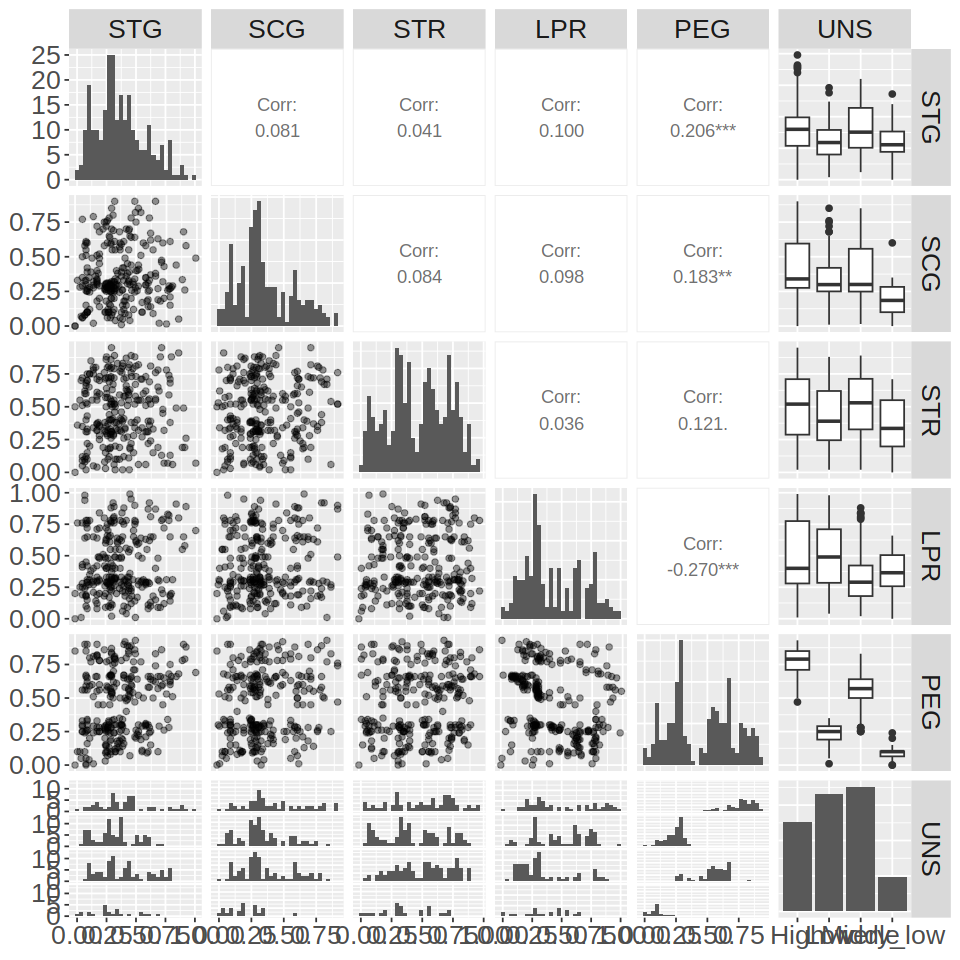

In [11]:
set.seed (1234)
options(repr.plot.width = 8, repr.plot.height = 8)

pairplot <- training_data |> 
     ggpairs(
         lower = list(continuous = wrap('points', alpha = 0.4)),
         diag = list(continuous = "barDiag")
     ) +
     theme(text = element_text(size = 20))

pairplot

<b> Figure 5: </b>

Comparison of the distributions of the variables

Since our predictors does not appears to have high correlation, we didn't expect our model to predict at a high level of accuracy. We see that the highest correlation is -0.270 between LPR and PEG

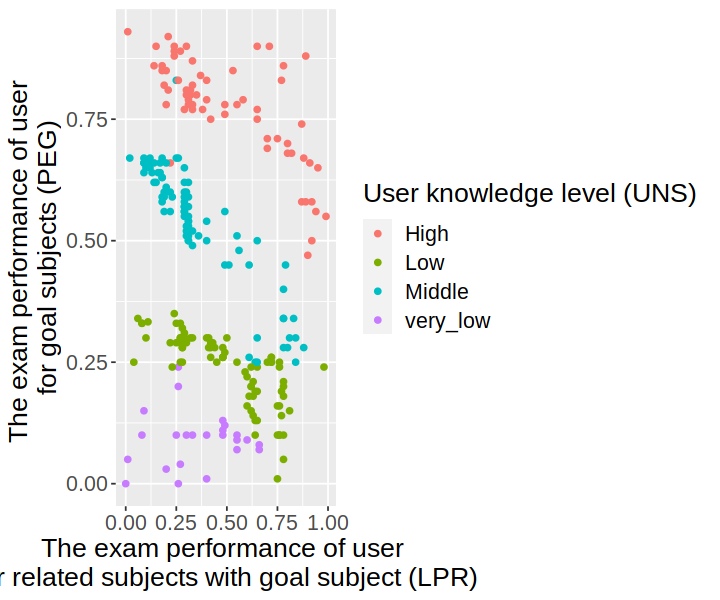

In [18]:
lpr_peg_plot

### Data Analysis -- K-nearest neighbor classification

In order to creat a knn classification model to predict a new observation, we need to is to find out the most 
accurate k value to use. The first step in choosing the parameter K is to generate five different validation sets.
Then, creating a specification model and build a recipe that involve UNS as class, LPR and PEG as predictors.
Finally, we create a workflow and use the tune_grid function to fit the model for each value in a range of parameter values.


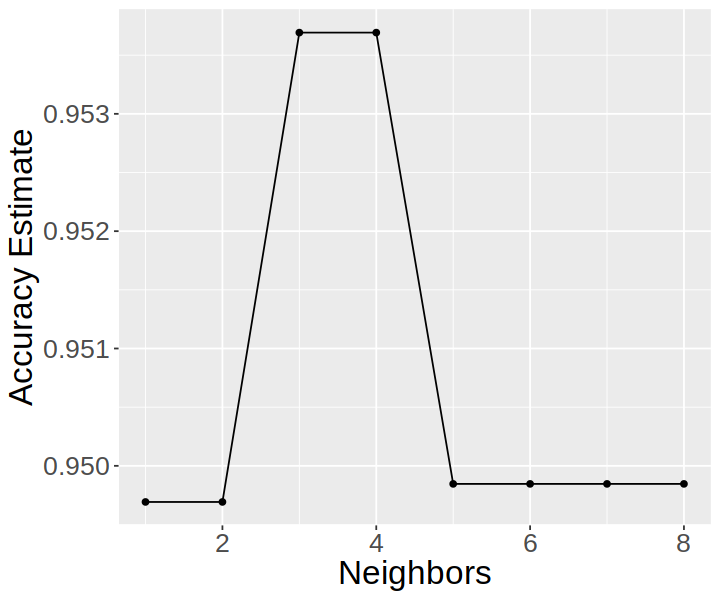

In [32]:
set.seed (1234)

options(repr.plot.height = 5, repr.plot.width = 6)

### BEGIN SOLUTION
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

mnist_recipe <- recipe(UNS ~ PEG + LPR, data = training_data)

mnist_vfold <- vfold_cv(training_data, v = 5, strata = UNS)

knn_results <- workflow() |>
                 add_recipe(mnist_recipe) |>
                 add_model(knn_spec) |>
                 tune_grid(resamples = mnist_vfold, grid = tibble(neighbors = c(1,2,3,4,5,6,7,8))) |>
                 collect_metrics()

accuracies <- knn_results |>
                 filter(.metric == 'accuracy')

cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
                  geom_point() +
                  geom_line() +
                  labs(x = 'Neighbors', y = 'Accuracy Estimate') +
                  theme(text = element_text(size = 20)) 

cross_val_plot

<b> Figure 6: </b>

Graph of Accuracy against Neighbors

We see that we get highest accuracy with 3 and 4 neighbors, but since we have 4 classes, we will choose 3 so there is no tie between the classes. We now put k = 3 directly into the specification instead of using tune() function and create a workflow to combine the new specification and recipe. Finally, we fit the training data.

In [35]:

new_training_data<-training_data|>
select(UNS, LPR, PEG) |>
mutate(LPR=as.numeric(LPR))|>
mutate(PEG=as.numeric(PEG)) |>
mutate(UNS = as.factor(str_replace(training_data$UNS, "Very Low", "very_low"))) 

new_testing_data<-testing_data|>
select(UNS, LPR, PEG)|>
mutate(LPR=as.numeric(LPR))|>
mutate(PEG=as.numeric(PEG)) |>
mutate(UNS = as.factor(str_replace(testing_data$UNS, "Very Low", "very_low")))

In [38]:
set.seed (1234)

pred1 <- tibble(LPR= 0.87, PEG=0.55)

recipe<-recipe(UNS~LPR+PEG, data=new_training_data)|>
 step_scale(all_predictors())|>
    step_center(all_predictors())

knn_spec<- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
       set_engine("kknn") |>
       set_mode("classification")


fit<- workflow() |>
          add_recipe(recipe) |>
          add_model(knn_spec) |>
          fit(data = new_training_data)

predicted1<-predict(fit, pred1)
predicted1

.pred_class
<fct>
High


<b> Figure 7: </b>

Predict a new observation's UNS level

In [39]:
set.seed (1234)
test_predictions <- predict(fit, new_testing_data) |>
  bind_cols(new_testing_data)


classification_metrics <- test_predictions |>
metrics(truth = UNS, estimate=.pred_class)|>
filter(.metric=="accuracy")


classification_metrics


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.9517241


<b> Figure 8: </b>

The accuracy of the k-nearest neighbor classification model

In [40]:
set.seed (1234)

conf_mat <- test_predictions |> 
      conf_mat(truth = UNS, estimate = .pred_class)

conf_mat

          Truth
Prediction High Low Middle very_low
  High       39   0      0        0
  Low         0  42      1        2
  Middle      0   3     33        0
  very_low    0   1      0       24

We assign the testing data into the classification model and compare the predictions and the actual UNS level of 
the observations in the testing dataset to get the accuracy of our model. We can combine the predictions with 
our actual dataset together and use metrics to calculate the accuracy.

We can see the accuracy is around 95% and the precision and recall  Therefore, this model is not a good classifier.

### Discussions

-it seems like study time does not have a strong impact on one's exam performance, more depends on their knowledge level.


### References

Kahraman,Hamdi, Colak,Ilhami, and Sagiroglu,Seref. (2013). User Knowledge Modeling. UCI Machine Learning Repository. https://doi.org/10.24432/C5231X.